<h1>Содержание<span class="tocSkip"></span></h1>
<li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод:</a></span></li>

#  Прогнозирование заказов такси

У нас есть исторические данные о заказах такси.  
Нужно спрогнозировать количество заказов такси на следующий час.    

Значение метрики *RMSE* на тестовой выборке должно быть <= 48.  
Количество заказов находится в столбце `num_orders`.  

## Подготовка

In [1]:

import warnings
import pandas as pd
import lightgbm as lgb
!pip install scikit-learn -U
from datetime import datetime
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore')
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
pd.set_option('display.max_colwidth', 200)
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose


Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: scikit-learn in /home/jovyan/.local/lib/python3.7/site-packages (0.24.2)


In [2]:
df = pd.read_csv('taxi.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Объем памяти занят не большой, оптимизация не требуется.  
Пропуски отсутствуют.  
Для удобства нужно преобразовать тип данных в столбце `datetime`  

In [4]:

df['datetime'] = df['datetime'].astype('datetime64')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Отлично, теперь даты сделаем индексом.

In [5]:
df.set_index(['datetime'], drop=True, inplace=True)

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Отсортируем даты и проверим что они изменяются монотонно.

In [7]:

df.sort_index(
    axis=0,
    ascending=True,
    inplace=True
)

df.index.is_monotonic


True

Так как мы хотим спрогнозировать количество заказов за час, то следует сделать почасовой расчет заказов.  

In [8]:
df = df.resample('1H').sum()

In [9]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Хорошо, теперь данные готовы к анализу.

### Вывод:

Данные агрегированы по часу, и готовы к анализу.  

## Анализ

Прежде всего давайте посмотрим на тренды и сезонность.

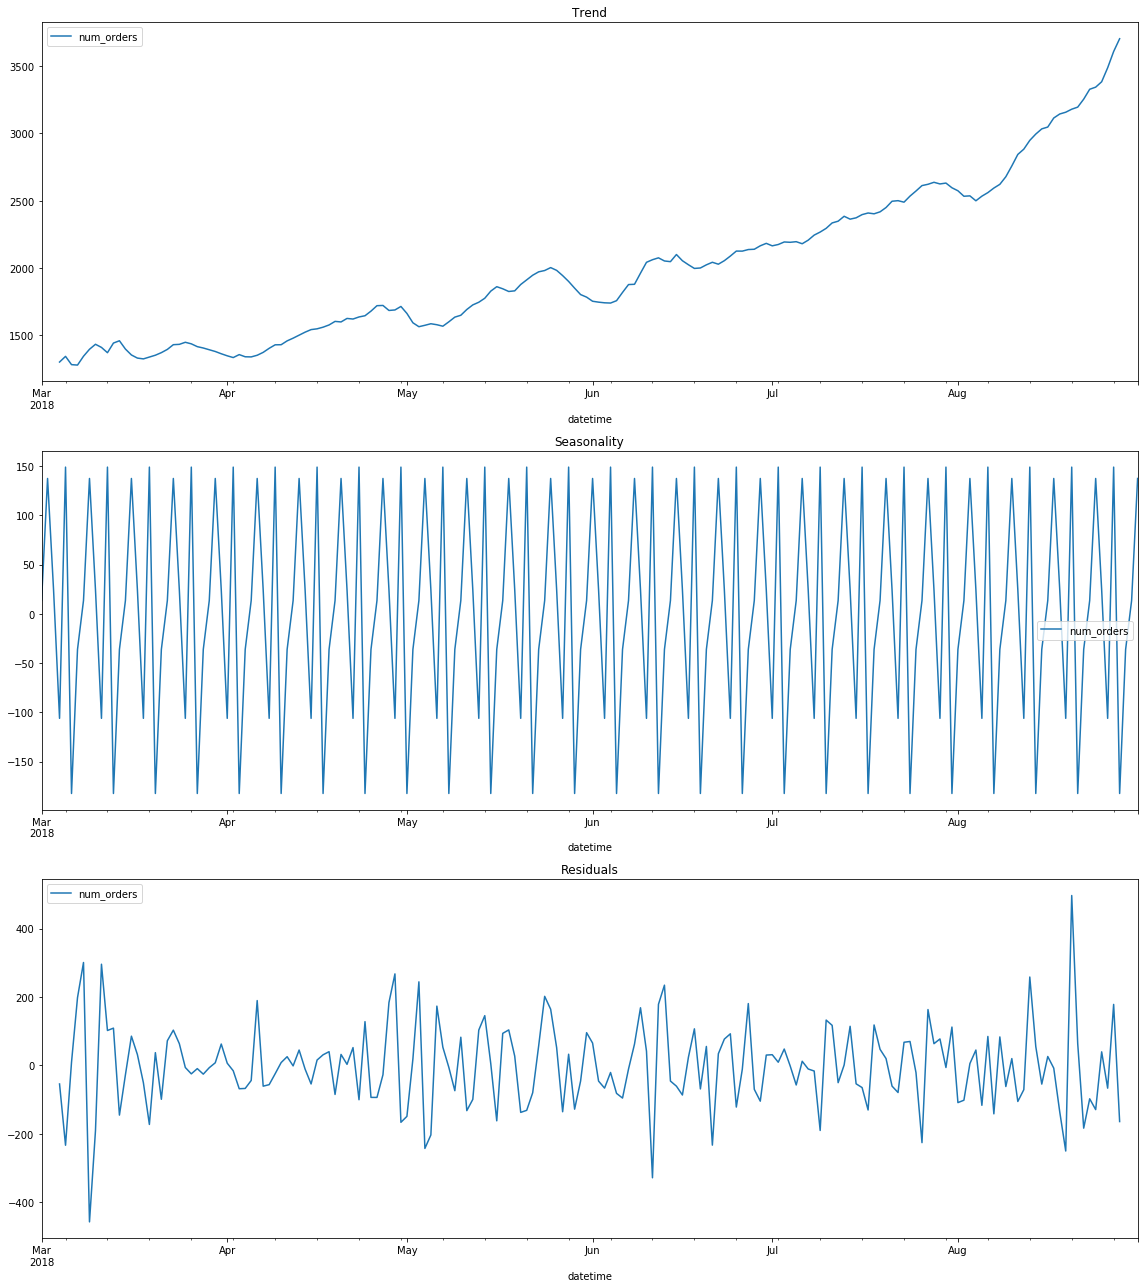

In [10]:

decomposed = seasonal_decompose(df.resample('D').sum()) # для наглядности пересоберем данные по дням

plt.figure(figsize=(16, 18))        # рисуем общую фигуру
plt.subplot(311)                    # добавляем на нее подфигуру (всего будет 3x1 подфигур, это первая)
decomposed.trend.plot(ax=plt.gca()) # на подфигуре рисуем график по полученным данным
plt.title('Trend')                  # даем заголовок
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


Видим восходящий тренд по количеству поездок с марта по сентябрь.  
Видна недельная сезонность, надо будет рассмотреть ее поближе.  
Остальное шум.  
Сделаем тоже самое, только по часам:  

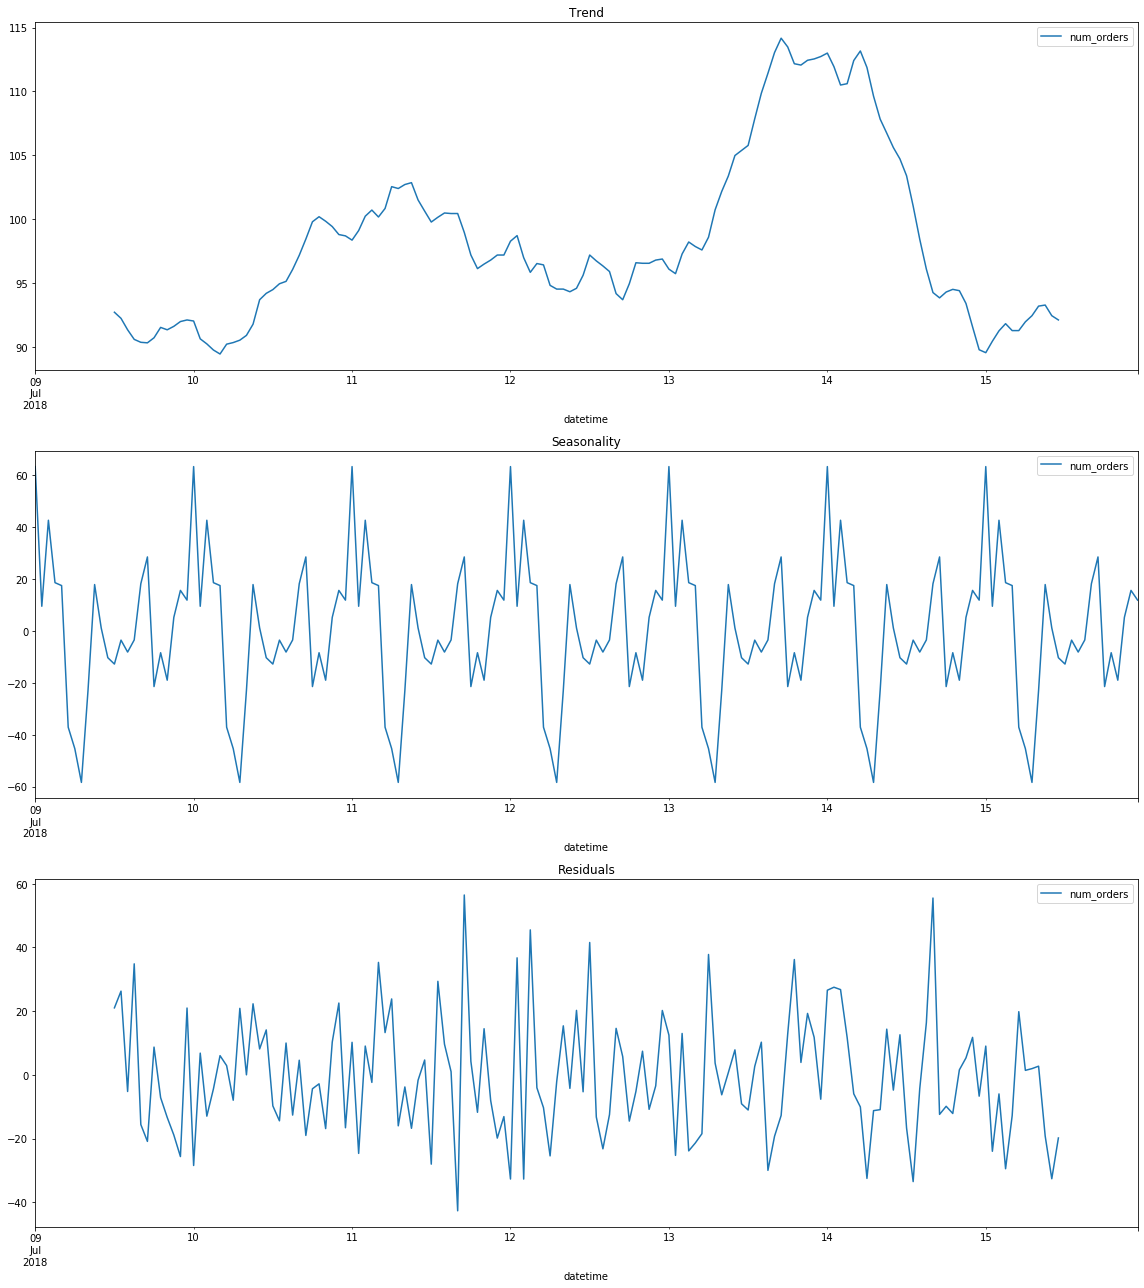

In [11]:

decomposed = seasonal_decompose(df['2018-07-09':'2018-07-15'].resample('1H').sum()) # для наглядности пересоберем данные по дням

plt.figure(figsize=(16, 18))        # рисуем общую фигуру
plt.subplot(311)                    # добавляем на нее подфигуру (всего будет 3x1 подфигур, это первая)
decomposed.trend.plot(ax=plt.gca()) # на подфигуре рисуем график по полученным данным
plt.title('Trend')                  # даем заголовок
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


В новой разбивке видим возрастающий тренд в начале и конце недели.  
Видим сезонность внутри дня, каждый раз количество заказов реско растет с утра, и к вечеру.  

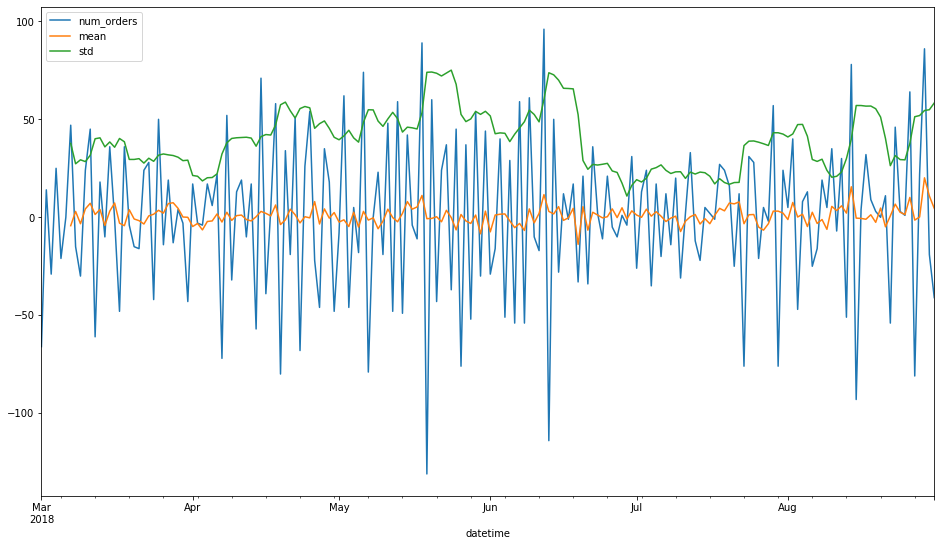

In [12]:

data = df - df.shift()
data = data.resample('D').sum()
data['mean'] = data['num_orders'].rolling(7).mean()
data['std'] = data['num_orders'].rolling(7).std()
data.plot(figsize=(16, 9));


По графику разности ряда видно, что с апреля, по середину июня, ряд изменяется сильнее всего.  
С середины июня, по третью неделю июля, наоборот, самое стабильное время.  

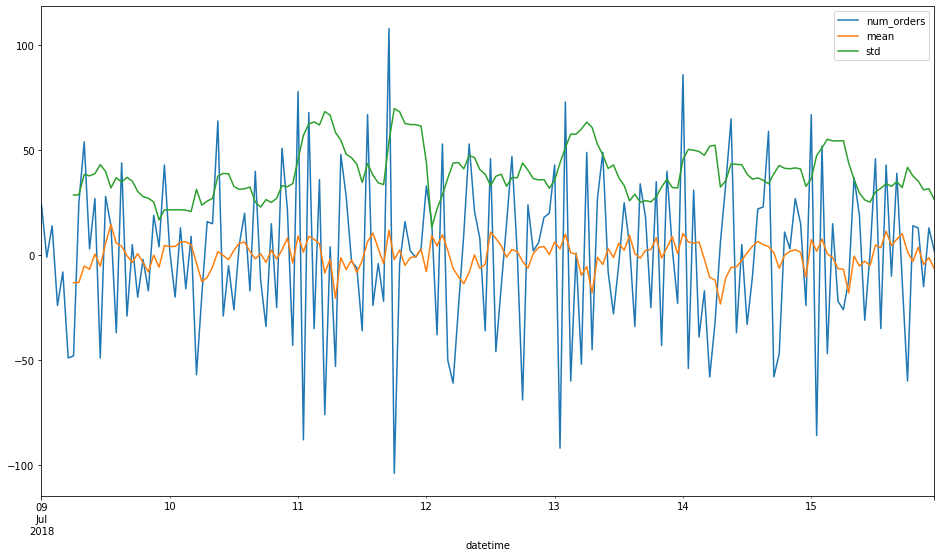

In [13]:

data = df - df.shift()
data = data['2018-07-09':'2018-07-15'].resample('1H').sum()
data['mean'] = data['num_orders'].rolling(7).mean()
data['std'] = data['num_orders'].rolling(7).std()
data.plot(figsize=(16, 9));


Со среды на четверг, в пятницу стандартное отклонение растет.  

### Вывод:

Мы нашли восходящий тренд по количеству поездок с марта по сентябрь.  
По графику разности ряда видно, что с апреля, по середину июня, ряд изменяется сильнее всего.  
С середины июня, по третью неделю июля, наоборот, самое стабильное время.  
В разбивке по часам за неделю видим возрастающий тренд, в начале и конце недели.  
Видим сезонность внутри дня, каждый раз количество заказов реско растет с утра, и к вечеру.  
Со среды на четверг, в пятницу стандартное отклонение растет.  

## Обучение

Время настраивать модели, готовиться к тестированию.   

In [14]:

# год у нас везде один, поэтому его не добавляем
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek


In [15]:
df.sample(5, random_state=42)

,num_orders,month,day,dayofweek
datetime,,,,
2018-05-07 15:00:00,62,5,7,0
2018-04-30 11:00:00,63,4,30,0
2018-08-13 16:00:00,144,8,13,0
2018-05-11 23:00:00,119,5,11,4
2018-03-07 00:00:00,100,3,7,2


Мы добавили признаки по дате.  
Теперь напишем функцию которая поможет добавить сдвинутые ряды в наш датасет.  

In [16]:

def make_features(
    data,
    max_lag,
    rolling_mean_size,
    target_column='num_orders'
):
    
    # добавим лаги
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] =\
        data[target_column].shift(lag)
        
    # добавим скользящее среднее
    data['rolling_mean'] =\
    data[target_column].shift().rolling(rolling_mean_size).mean()
    
    return data
    

In [17]:

# не будем менять изначальный датасет
data = make_features(df.copy(), 24, 4)


Разобьем датасет на тренировочную и тестовые выборки:  

In [18]:

train, test = train_test_split(
    data,
    shuffle=False, # не перемешиваем, сохраняем линию времени
    test_size=0.1
)
    
train = train.dropna()
    
y_train = train['num_orders']
y_test = test['num_orders']
X_train = train.drop(['num_orders'], axis = 1)
X_test = test.drop(['num_orders'], axis = 1)
    

Подберем параметры на тренировочной выборке:  

In [19]:

# для скорости проверки, диапазоны параметров уже указаны близко к оптимальным, вычисленным ранее
grid = {
    'LR': {
        'model': LinearRegression(),
        'parameters': {}
    },
    'DTR': {
        'model': DecisionTreeRegressor(random_state=42),
        'parameters': {
            'criterion': ['mse', 'friedman_mse'],
            'max_depth': [x for x in range(2, 5, 1)]
        }
    },
    'RFR': {
        'model': RandomForestRegressor(random_state=42),
        'parameters': {
           'n_estimators': [x for x in range(380, 400, 20)],
           'max_depth': [x for x in range(18, 20, 2)]
        }
    },
    'LGBM': {
        'model': lgb.LGBMModel(),
        'parameters': {
            'learning_rate': [0.06, 0.08, 0.1],
            'objective': ['regression'],
            'max_depth': [x for x in range(2, 4, 1)],
            'n_estimators': [x for x in range(50, 100, 50)],
            'num_iterations': [x for x in range(300, 350, 50)],
            'boosting': ['gbdt']
        }
    },
    'CBR': {
        'model': CatBoostRegressor(),
        'parameters': {
            'max_depth': [x for x in range(6, 7, 1)],
            'n_estimators': [1000],
            'loss_function': ['RMSE'],
            'silent': [True] # не будем печатать каждую итерацию
        }
    }
}


In [20]:

RMSE = make_scorer(
    mean_squared_error,
    squared=False, # False берет корень квадратный из MSE, получаем RMSE
    greater_is_better=False
)

scores = []
start_time = datetime.now()

for model, parameter in grid.items():
    GS_CV = GridSearchCV(parameter['model'], 
                         parameter['parameters'], 
                         scoring = RMSE, 
                         # с временным рядом нам важна последовательность, поэтому кроссвалидация особенная
                         cv=TimeSeriesSplit(n_splits=5)
                        )
    GS_CV.fit(X_train,  y_train)
    scores.append({
    'model': model,
     # умножая на -1 возвращаем верный знак нашей оценке
    'best_train_score': round(GS_CV.best_score_ * -1, 2), 
    'best_parameters': GS_CV.best_params_
    })
        
print('Время работы (ч:м:с.мс) {}'.format(datetime.now()-start_time))


Время работы (ч:м:с.мс) 0:04:32.586531


In [21]:

models_analysis = pd.DataFrame(scores, columns=[
    'model',
    'best_parameters',
    'best_train_score',
    'test_score',
    'test_training_time', 
    'test_prediction_time'
])
models_analysis.iloc[:, :3].sort_values(by=['best_train_score'])


,model,best_parameters,best_train_score
4,CBR,"{'loss_function': 'RMSE', 'max_depth': 6, 'n_estimators': 1000, 'silent': True}",24.60
3,LGBM,"{'boosting': 'gbdt', 'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 50, 'num_iterations': 300, 'objective': 'regression'}",25.58
2,RFR,"{'max_depth': 18, 'n_estimators': 380}",25.67
0,LR,{},27.02
1,DTR,"{'criterion': 'mse', 'max_depth': 4}",30.68


### Вывод:

Мы подготовили параметры для пяти моделей, теперь пора проверить их на тестойвой выборке.  

## Тестирование

In [22]:

LR = LinearRegression()

DTR = DecisionTreeRegressor(
    max_depth=3,
    criterion='mse',
    random_state=123
)

RFR = RandomForestRegressor(
    max_depth=18,
    n_estimators=380,
    random_state=123
)

LGBM = lgb.LGBMModel(
    learning_rate=0.06,
    objective='regression',
    max_depth=2,
    n_estimators=50,
    num_iterations=300,
    boosting='gbdt'
)

CBR = CatBoostRegressor(
    max_depth=6,
    n_estimators=1000,
    loss_function = 'RMSE',
    silent = True
)

models = [LR, DTR, RFR, LGBM, CBR]


In [23]:

for i, model in enumerate(models):
    start_time = datetime.now()
    model.fit(X_train, y_train)
    models_analysis['test_training_time'][i] = datetime.now() - start_time
    
    start_time = datetime.now()
    predictions = model.predict(X_test)
    models_analysis['test_prediction_time'][i] = datetime.now() - start_time
    
    models_analysis['test_score'][i] = round(mean_squared_error(y_test, predictions, squared=False), 2)
    

In [24]:
models_analysis['running_time_total'] = models_analysis['test_training_time'] + models_analysis['test_prediction_time']

In [25]:
models_analysis.sort_values(by=['test_score'])

,model,best_parameters,best_train_score,test_score,test_training_time,test_prediction_time,running_time_total
4,CBR,"{'loss_function': 'RMSE', 'max_depth': 6, 'n_estimators': 1000, 'silent': True}",24.60,40.53,0:00:35.477841,0:00:00.008593,00:00:35.486434
2,RFR,"{'max_depth': 18, 'n_estimators': 380}",25.67,43.82,0:00:25.919038,0:00:00.129926,00:00:26.048964
3,LGBM,"{'boosting': 'gbdt', 'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 50, 'num_iterations': 300, 'objective': 'regression'}",25.58,43.92,0:00:20.131373,0:00:00.023985,00:00:20.155358
0,LR,{},27.02,45.53,0:00:00.021116,0:00:00.005171,00:00:00.026287
1,DTR,"{'criterion': 'mse', 'max_depth': 4}",30.68,56.36,0:00:00.114011,0:00:00.002988,00:00:00.116999


Самым точным алгоритмом стал `CatBoost`  
Но `LightGBM` быстрее, хоть и не такой точный.  
Оба уложились в ограничение ошибки предсказания  <= 48

## Общий вывод:

Мы нашли восходящий тренд по количеству поездок с марта по сентябрь.  
По графику разности ряда видно, что с апреля, по середину июня, ряд изменяется сильнее всего.  
С середины июня, по третью неделю июля, наоборот, самое стабильное время.  
В разбивке по часам за неделю видим возрастающий тренд, в начале и конце недели.  
Видим сезонность внутри дня, каждый раз количество заказов реско растет с утра, и к вечеру.  
Со среды на четверг, в пятницу стандартное отклонение растет.  
Самым точным алгоритмом стал `CatBoost`  
Но `LightGBM` быстрее, хоть и не такой точный.  
Оба уложились в ограничение ошибки предсказания  <= 48